# Exercise 5: ML - Grundlagen und Algorithm, 28 Pts

Extended Deadline: July 19 15:00

## 0.) Reminders
Please adhere to the hand-in conventions specified in the 0-th exercise sheet, i.p.,
- You have to **submit the jupyter notebook file as well as the PDF**!
- Please **adhere to the zip naming conventions**!

# 1.) Rejection Sampling (6 Points)
In this exercise you will implement rejection sampling step by step.

In [1]:
# First, let us import some libraries. Please note that we are using PyTorch again.
import torch
from torch.distributions import Normal
import math
import matplotlib.pyplot as plt

### Goal
The goal of rejection sampling is to sample from a target density $x \sim p(x)$ only having access to the un-normalized target density $ = \tilde{p}(x) = Zp(x)$ with $Z=\int \tilde{p}(x) dx$.

### Target Density $\tilde{p}(x)$
 Let's define the target distribution. In this case it is a Gaussian mixture model (GMM). Please note that it is straightforward to sample from a GMM. However, for demonstration purposes, we assume that it is not possible and we use rejection sampling to obtain samples.

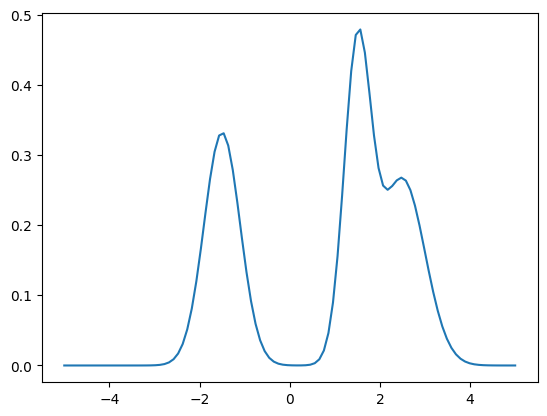

In [2]:
class TargetDist:
    def __init__(self, means=[-1.5, 1.5, 2.5], stds=[0.4, 0.3, 0.5]):
        """
        :param means: Means for the Gaussian mixture components
        :param stds: Standard deviations for the Gaussian mixture components
        """
        self.means = means
        self.stds = stds

    def probs(self, samples):
        """
        :param samples: Samples we want to evaluate ̃p(x)
        :return: ̃p(x)
        """
        gaussian_log_probs = [Normal(loc=self.means[i], scale=self.stds[i]).log_prob(samples) for i in range(len(self.means))]
        return torch.exp(torch.logsumexp(torch.cat(gaussian_log_probs,-1), -1) - math.log(len(self.means)))

# Let us plot the target density
x = torch.linspace(-5, 5, 100).reshape(-1,1)
plt.plot(x, TargetDist().probs(x))
plt.show()

### 1.1) Proposal Distribution $q(x)$ (2 Points)
Next, we need to define a proposal distribution $q(x)$ where we can easily sample from. In this exercise we use a Gaussian distribution $q(x) = \mathcal{N}(\mu, \sigma^2)$. For the proposal distribution we need to operations:
- We need to be able to evaluate the likelihood $q(x)$
- We need to be able to sample from $q(x)$

Implement these operations in the following template class!

In [3]:
class GaussianProposalDist:
    def __init__(self, mean=0., std=1.5):
        """
        :param mean: Mean of the Gaussian proposal distribution
        :param std: Standard deviation of the Gaussian proposal distribution
        """
        self.means = mean
        self.stds = std
        self.proposal_dist = Normal(mean, std)


    def probs(self, samples):
        """
        :param samples: Samples x to evaluate q(x)
        :return: q(x)
        """
        ############################################################
        # TODO Compute q(x)
        ############################################################
        return self.proposal_dist.log_prob(samples).exp()


    def sample(self, n_samples):
        """
        :param n_samples: Number of samples to draw from q(x)
        :return: x ~ q(x)
        """
        ############################################################
        # TODO Draw samples x ~ q(x)
        ############################################################
        return self.proposal_dist.sample((n_samples,))


Next, we need to find a $c$ such that $\forall x \in \mathbb{R}: cq(x) \geq \tilde{p}(x)$. Since, the target distribution only has significant probability mass in $I = [-5,5]$ we are looking for a $c$ that full-fills the condition on $I$.


In [4]:
I = torch.linspace(-5,5, 1000).reshape(-1,1)
q = GaussianProposalDist()
p_tilde = TargetDist()

q_x = q.probs(I)
p_tilde_x = p_tilde.probs(I)
############################################################
# TODO Compute c such that it full-fills the condition above
############################################################
c = (p_tilde_x / q_x).max()

Lets do a quick sanity check by visualizing the result:

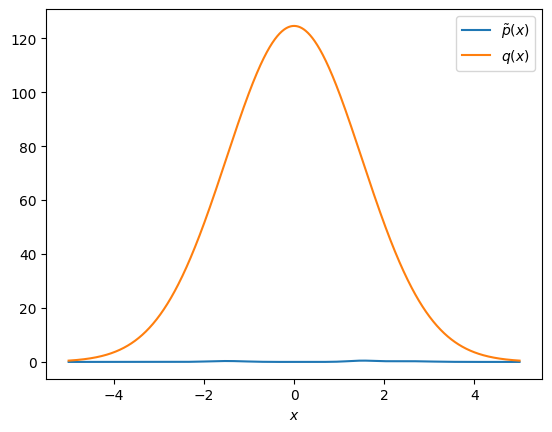

In [5]:
plt.plot(I, p_tilde_x, label='$\\tilde{p}(x)$')
plt.plot(I, c * q_x, label='$q(x)$')
plt.xlabel('$x$')
plt.legend()
plt.show()

### 1.2) Sampling (4 Points)

Now we have everything to perform rejection sampling which involves the following three steps:
1. Draw samples $s \sim q(x)$
2. Draw samples $u \sim \text{Uniform}[0, cq(s)]$
3. Reject $s$ if $u > \tilde{p}(s)$ else accept

In the following you are tasked to implement these three steps. Save the accepted as well as the rejected samples!

In [6]:
N_SAMPLES = 500
############################################################
# TODO 1. Draw samples s ~ q(x)
############################################################
proposal_samples = q.sample(N_SAMPLES)
############################################################
# TODO 2. Draw samples u ~ Uniform[0, cq(s)]
############################################################
uniform_samples = c * q.probs(proposal_samples)
############################################################
# TODO 2. Compute accepted and rejected samples
############################################################
# Bug:  Dimension out of range (expected to be in range of [-1, 0], but got 1)
tilde_samples = p_tilde.probs(proposal_samples)
mask = uniform_samples <= tilde_samples # Use a mask to find the accepted and rejected samples
accepted = proposal_samples[mask]
rejected = proposal_samples[~mask]


Lastly, we visualize the accepted and rejected samples

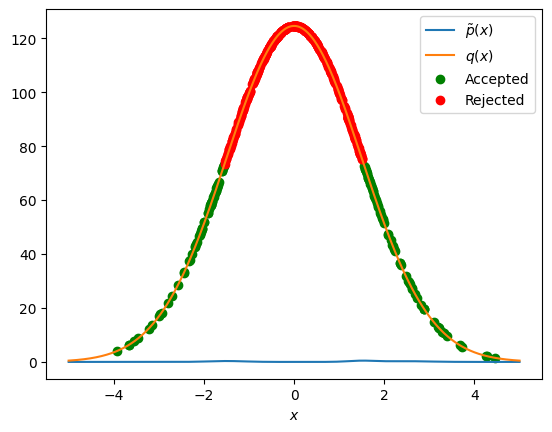

In [7]:
plt.plot(I, p_tilde_x, label='$\\tilde{p}(x)$')
plt.plot(I, c * q_x, label='$q(x)$')
plt.scatter(accepted, uniform_samples[mask], c='g', label='Accepted')
plt.scatter(rejected, uniform_samples[~mask], c='r', label='Rejected')
plt.xlabel('$x$')
plt.legend()
plt.show()

## 2.) Metropolis-Hastings MCMC (8 Points)
In this exercise you will implement Metropolis-Hastings MCMC step by step.

### Goal
The goal of Markov Chain Monte Carlo is to sample from a target density $x \sim p(x)$ only having access to the un-normalized target density $ = \tilde{p}(x) = Zp(x)$ with $Z=\int \tilde{p}(x) dx$.

### Target Density $\tilde{p}(x)$
 Let's define the target distribution. In this case it is a Gaussian mixture model (GMM). Please note that it is straightforward to sample from a GMM. However, for demonstration purposes, we assume that it is not possible and we use rejection sampling to obtain samples.

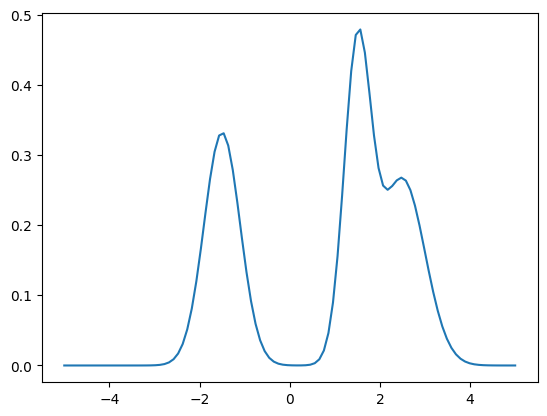

In [8]:
class TargetDist:
    def __init__(self, means=[-1.5, 1.5, 2.5], stds=[0.4, 0.3, 0.5]):
        """
        :param means: Means for the Gaussian mixture components
        :param stds: Standard deviations for the Gaussian mixture components
        """
        self.means = means
        self.stds = stds

    def probs(self, samples):
        """
        :param samples: Samples we want to evaluate ̃p(x)
        :return: ̃p(x)
        """
        if samples.dim() == 1:
            samples = samples.reshape(1, -1)

        gaussian_log_probs = [Normal(loc=self.means[i], scale=self.stds[i]).log_prob(samples) for i in range(len(self.means))]
        return torch.exp(torch.logsumexp(torch.cat(gaussian_log_probs,1), 1) - math.log(len(self.means)))

# Let us plot the target density
x = torch.linspace(-5, 5, 100).reshape(-1,1)
plt.plot(x, TargetDist().probs(x))
plt.show()

### 2.1) Proposal Distribution $q(x|x_t)$ (3 Points)
Next, we need to define a proposal distribution $q(x|x_t)$ where we can easily sample from. In this exercise we use a Gaussian distribution $q(x|x_t) = \mathcal{N}(x_t, \sigma^2)$. For the proposal distribution we need to operations:
- We need to be able to evaluate the likelihood $q(x|x_t)$
- We need to be able to sample from $q(x|x_t)$

Implement these operations in the following template class!

In [9]:
from torch.distributions import MultivariateNormal


class GaussianProposalDist:
    def __init__(self, proposal_std=1):
        """
        :param proposal_std: Standard deviation of the proposal distribution
        """
        self.proposal_std = proposal_std

    def probs(self, current_location, samples):
        """
        :param current_location: Current location x_t of the proposal distribution q(x|x_t)
        :param samples: Samples x to evaluate q(x|x_t)
        :return: q(x|x_t)
        """
        ############################################################
        # TODO Compute q(x|x_t)
        ############################################################
        diff = samples - current_location
        exponent = -0.5 * (diff / self.proposal_std) ** 2
        normalization = 1.0 / (self.proposal_std * math.sqrt(2 * math.pi))
        return normalization * torch.exp(exponent)



    def sample(self, current_location):
        """
        :param current_location: Current location x_t of the proposal distribution q(x|x_t)
        :return: x ~ q(x|x_t)
        """
        ############################################################
        # TODO Draw samples x ~ q(x|x_t)
        ############################################################
        return current_location + torch.randn_like(current_location) * self.proposal_std

### 2.2) Sampling (5 Points)

Now we have everything to perform Metropolis Hastings MCMC which involves the following steps to obtain one sample:
1. Given current location $x_t$
2. Draw proposal $x \sim q(x|x_t)$
3. Evaluate $r = \tilde{p}(x)/\tilde{p}(x_t)$ (as $q(x|x_t) = q(x_t|x)$)
4. If: $ r \geq 1$: $x_{t+1} \leftarrow x$
5. Else: accept with probability $r$ ($x_{t+1} \leftarrow x$), stay with probability $1-r$ ($x_{t+1} \leftarrow x_t$)

In the following you are tasked to implement these three steps. Save the accepted as well as the rejected samples!

In [10]:
N_SAMPLES = 1000
PROPOSAL_STD = 1.
initial_location = torch.tensor([0.])

proposal_dist = GaussianProposalDist(PROPOSAL_STD)
target_dist = TargetDist()

sample_dim = initial_location.shape[0]  # Dimensionality of x
samples = torch.zeros([N_SAMPLES, sample_dim])  # Fill this tensor with samples
current_location = initial_location  # x_t for t = 0
for i in range(N_SAMPLES):
    ############################################################
    # TODO 2. Draw sample x ~ q(x|x_t)
    ############################################################
    proposal = proposal_dist.sample(current_location)
    ############################################################
    # TODO 3. Evaluate acceptance ration r
    ############################################################
    numerator = target_dist.probs(proposal) * proposal_dist.probs(proposal, current_location)
    denominator = target_dist.probs(current_location) * proposal_dist.probs(current_location, proposal)
    r = numerator / denominator
    ############################################################
    # TODO 4. Check if r >= 1. If so, accept the sample
    ############################################################
    if r >= 1.:
        samples[i] = proposal
        current_location = proposal
    else:
    ############################################################
    # TODO 5. If r < 1 accept the sample with probability r else stay
    ############################################################
        accept = torch.rand(1) < r
        if accept:
            samples[i] = proposal
            current_location = proposal
        else:
            samples[i] = current_location


Lastly, we visualize the samples obtained by the Metropolis-Hastings MCMC algorithm

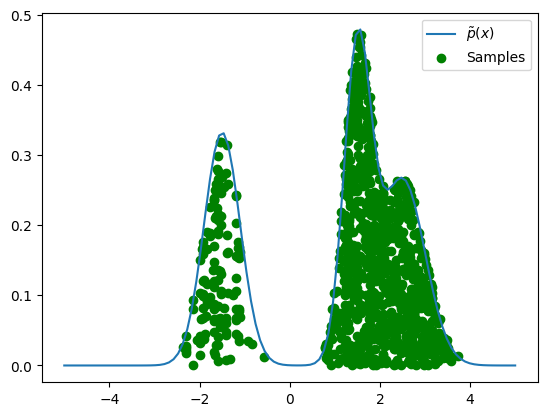

In [11]:
x = torch.linspace(-5, 5, 100).reshape(-1, 1)
u = torch.rand(N_SAMPLES) * target_dist.probs(samples)
plt.plot(x, target_dist.probs(x), label='$\\tilde{p}(x)$')
plt.scatter(samples, u, c='g', label='Samples')
plt.legend()
plt.show()

# 3) Bayesian Neural Networks (BNN) 14 Points

Ge Li, ge.li@kit.edu

## Guideline
In this exercise, you are going to implement a few BNN algorithms and compare their predictions in a binary classification task. We use PyTorch as our neural network toolbox and structure the algorithms using the Object-Oriented-Programming manner.

The algorithms include: MAP, SWAG, MCD and their corresponding ensembles, i.e. Deep Ensemble, Multi-SWAG, Multi-MCD.
<br>

### Big Picture and Workflow
- We offered a few utilities functions to load dataset, evaluate models and plot classification results.
- We offered the Maximum A Posteriori (MAP) binary classifier as our base algorithm.
- You are going to implement a class **EnsembleWrapper** which can store multiple instances of a single algorithm to make them an ensemble model.
- You are going to implement SWAG and MCD methods. They inherit the MAP class and can thus reuse part of the code.
<br>

### Acknowledgement
Special thanks to Florian Seligmann. Some of the content in this homework is adapted from his bachelor's thesis codebase.

### Install Dependencies
We need to install a package **tqdm** to show the progress bar of our training and plotting process.
Call **conda install -c conda-forge tqdm** to install it.



## Load and Plot Dataset
We will use our best friend **Two-Moon Dataset** for our homework. This time, we added more noise to our dataset.

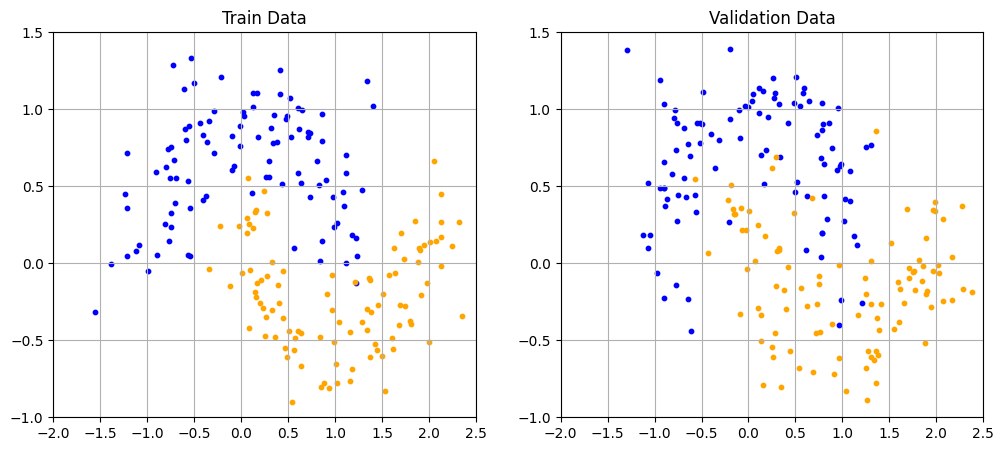

In [12]:
import numpy as np
import torch

from util import plot_dataset

two_moon_dataset = np.load("bnn_dataset.npz", allow_pickle=True)
train_data_x, train_data_y = two_moon_dataset["train_data_x"], two_moon_dataset[
    "train_data_y"]
val_data_x, val_data_y = two_moon_dataset["val_data_x"], two_moon_dataset[
    "val_data_y"]
test_data_x, test_data_y = two_moon_dataset["test_data_x"], two_moon_dataset[
    "test_data_y"]

# Transfer numpy array into torch tensor
train_samples_tensor = torch.as_tensor(train_data_x, dtype=torch.float32)
train_labels_tensor = torch.as_tensor(train_data_y, dtype=torch.long)
test_samples_tensor = torch.as_tensor(val_data_x, dtype=torch.float32)
test_labels_tensor = torch.as_tensor(val_data_y, dtype=torch.long)

# Plotting
plot_dataset(train_data_x, train_data_y, val_data_x, val_data_y)

## Hyperparameters
We define a few hyperparameters here. You can change them to see how they affect the results.

In [13]:
lr = 0.05  # Learning rate
wd = 1e-4  # Weight decay, the L2 regularization term
num_h_neuron = 64  # Number of neurons in the hidden layers of the NN
dropout_p = 0.25  # The probability of a neuron being dropped out
max_epoch = 1000  # Max training episode
seed = 0  # Random seed to ensure reproducibility
swag_start = max_epoch - 600  # From this epoch will SWAG start updating
swag_update_interval = 5  # SWAG update interval
n_ensemble = 5  # Number of method instances in the Multi-X models.
num_smp = 100  # Number of parameter samples from the posterior distribution of each single method instance
plot_density = 0.02  # The pixel size of the contour. Use bigger values if you face problems in plotting the result.

## Maximum A Posteriori
We define **MAPBinaryClassifier** to perform binary classification following the MAP manner. As introduced in the lecture, MAP is equivalent to train a neural network with L2 regularization.
This class includes 4 functions:
- init: instantiate one net and one optimizer for the model
- train_one_epoch: apply one train iteration using the training and validation datasets. Here, as our datasets are rather small, we feed the entire datasets without using minibatch.
- step: given input and label, compute the loss function and accuracy of the classification
- inference: given input, compute the probabilities of classification

This class serves as the super class and will be further extended in **SWAGBinaryClassifier** and **MCDBinaryClassifier** classes.

In [14]:
import torch.nn as nn
from torch.optim import SGD


class MAPBinaryClassifier:
    def __init__(self, **kwargs):
        # nn.Sequential is a container for a sequence of neural network layers
        # Call self.net(x) will sequentially apply the layers to the input x
        self.net = nn.Sequential(nn.Linear(2, num_h_neuron),
                                 nn.ReLU(),
                                 nn.Linear(num_h_neuron, num_h_neuron),
                                 nn.ReLU(),
                                 nn.Linear(num_h_neuron, num_h_neuron),
                                 nn.ReLU(),
                                 nn.Linear(num_h_neuron, 2),
                                 nn.LogSoftmax(dim=-1))

        # SGD Optimizer, lr is the learning rate,
        # weight_decay is the L2 regularization factor
        self.optimizer = SGD(self.net.parameters(), lr=lr, weight_decay=wd)

    def train_one_epoch(self, train_x, train_y, val_x, val_y):
        """
        Apply one train iteration using the training and validation datasets.
        Here we feed the entire datasets without using minibatch.
        """

        # Training
        self.net.train() # Set the model to training mode
        self.optimizer.zero_grad()
        loss, train_accuracy = self.step(train_x, train_y)
        loss.backward()
        self.optimizer.step()

        # Validation
        self.net.eval() # Set the model to evaluation mode
        with torch.no_grad(): # Turn off gradient computation under this context
            _, val_accuracy = self.step(val_x, val_y)

        # Return
        return train_accuracy, val_accuracy

    def step(self, x, y):
        """
        Given input and label, compute the cross-entropy loss function and accuracy
        """
        pred_log_prob = self.net(x)
        pred_class = pred_log_prob.argmax(dim=-1)
        loss = nn.functional.nll_loss(pred_log_prob, y)
        num_data = x.shape[0]
        num_pred_correct = (pred_class == y).sum().item()
        accuracy = num_pred_correct / num_data
        return loss, accuracy

    # The method decorator @torch.no_grad() disables gradient computation
    @torch.no_grad()
    def inference(self, x):
        self.net.eval()  # Set the model to evaluation mode
        # Compute the probability of each class given the log-probability
        pred_prob = self.net(x).exp()
        return pred_prob


## Deep Ensemble
A Deep Ensemble model contains multiple MAP model instances. When doing inference, the predictions of each instance will be averaged as the resulting prediction.

### Task 3.1: Ensemble wrapper (2 Points)
Indeed, any Multi-X methods can be implemented in a similar way, i.e. using an ensemble wrapper to make a single method "Multi". Therefore, in this homework, we will firstly implement this Ensemble Wrapper, and then always use this wrapper to instantiate our method. If the number of ensemble instances is 1, the resulting method is just a single method. Otherwise, it is a Multi-X method.

For convenience and simplicity, we also implement the main training loop in this wrapper class.


In [15]:
# tqdm is a package offering nice look progress bar
from tqdm import tqdm
# We always set the random seed to ensure reproducibility
from util import set_random_seed_globally


class EnsembleWrapper:
    def __init__(self, num_ensemble, model_class, **kwargs):
        """
        Create method ensemble
        Args:
            num_ensemble: the number of base models, 1 for single method, > 1 for Multi-method
            model_class: class name of the single method
            **kwargs: other keyword arguments specific to the single method init function
        """
        self.n_ensemble = num_ensemble
        set_random_seed_globally(seed)
        self.models = [model_class(**kwargs) for _ in range(num_ensemble)]

    def train_model(self, train_x, train_y, val_x, val_y):
        """
        Train all model instances in the ensemble
        """

        # Loop over models
        for i, model in enumerate(self.models):

            # Loop over training iterations
            pbar = tqdm(range(max_epoch))  # progress bar

            for epoch in pbar:
                train_accuracy, val_accuracy = \
                    model.train_one_epoch(train_x, train_y, val_x, val_y)

                # Logging and updating progress bar
                pbar.set_postfix({"Model": i + 1, "Epoch": epoch + 1,
                                  "train_accuracy": train_accuracy,
                                  "val_accuracy": val_accuracy})

    @torch.no_grad()
    def ensemble_inference(self, x):
        """
        Aggregate inference result of each model instance
        """
        ######################### Your code starts here #########################
        # Loop over each method instance
        # Todo
        ensemble_predictions = []
        for model in self.models:
            predictions = model.inference(x)
            ensemble_predictions.append(predictions)
        # Aggregate the predictions
        # Todo
        ensemble_predictions = torch.stack(ensemble_predictions, dim=0)
        ensemble_prediction = ensemble_predictions.mean(dim=0)
        ######################### Your code ends here #########################
        return ensemble_prediction


### MAP and DeepEnsemble-5 instances
Verify your implementation by training a MAP instance and a DeepEnsemble-5 instance.

In [16]:
import time
# MAP, num_ensemble = 1
max_a_p = EnsembleWrapper(num_ensemble=1,
                          model_class=MAPBinaryClassifier)
print("Training MAP")
time.sleep(0.3) # Sleep for 0.3 second to ensure the print function won't break the progress bar
max_a_p.train_model(train_samples_tensor, train_labels_tensor,
                    test_samples_tensor, test_labels_tensor)

Training MAP


100%|██████████| 1000/1000 [00:11<00:00, 85.15it/s, Model=1, Epoch=1000, train_accuracy=0.975, val_accuracy=0.92]


In [17]:
# Deep Ensemble, we ensemble 5 MAP instances
deep_ensemble_5 = EnsembleWrapper(num_ensemble=n_ensemble,
                                  model_class=MAPBinaryClassifier)
print("Training DeepEnsemble5")
time.sleep(0.3)
deep_ensemble_5.train_model(train_samples_tensor, train_labels_tensor,
                            test_samples_tensor, test_labels_tensor)

Training DeepEnsemble5


100%|██████████| 1000/1000 [00:04<00:00, 204.10it/s, Model=5, Epoch=1000, train_accuracy=0.975, val_accuracy=0.92]


## Stochastic Weight Averaging Gaussian (SWAG)
SWAG uses the parameters of the NN at different training stages to fit the approximated posterior distribution, known as a Multivariate Gaussian distribution. We implement it by using and extending the MAP as the super class.
<br>

The training procedure of a SWAG can be described as:
- Train a SWAG as we train an MAP classifier until convergence.
- Then keep training it and collect the parameters of the NN at different further $T$ training stages.
- The parameters collected at a certain stage (reshaped as a parameter vector $\boldsymbol\theta_i$ ) can be considered as a sample of the approximated posterior distribution.
- We use all these collected samples to compute the posterior distribution, in terms of the mean and covariance.
- With mean $\overline{\boldsymbol\theta} = \frac{1}{T} \sum^T_{i=1}\boldsymbol\theta_i$ and covariance $\boldsymbol\Sigma = \frac{1}{T-1} \sum^T_{i=1}(\boldsymbol\theta_i - \boldsymbol\theta)(\boldsymbol\theta_i - \boldsymbol\theta)^\intercal = \frac{1}{T-1} \boldsymbol{D} \boldsymbol{D}^\intercal$
- To decrease memory usage, we avoid saving all individual samples. Instead, each time when we get a new sample, we update a few intermediate variables, including the running mean $\overline{\boldsymbol\theta}$, mean of square $\overline{\boldsymbol\theta^2}$ and the deviation $\boldsymbol d$ of the parameter vector. We store the last K deviations, resulting a low-rank deviation matrix $\boldsymbol{D}_{lr}$.

\begin{align*}
        \text{Update mean:} \quad \overline{\boldsymbol\theta} \leftarrow \frac{i \overline {\boldsymbol\theta} + {\boldsymbol\theta_i}}{i + 1} \\
        \text{Update mean square:} \quad \overline{\boldsymbol\theta^2} \leftarrow \frac{i \overline {\boldsymbol\theta^2} + {\boldsymbol\theta^2_i}}{i + 1} \\
        \text{Compute deviation:} \quad {\boldsymbol d_i} = \boldsymbol\theta - \overline{\boldsymbol\theta_i}\\
        \text{Store deviation:} \quad {\boldsymbol D_{lr}}.\text{pop(0)}, \quad {\boldsymbol D_{lr}}.\text{add}{(\boldsymbol d_i)}
\end{align*}
<br>

The inference procedure can be described as:
- Approximate the covariance matrix $\boldsymbol\Sigma$ using the low-rank deviation matrix $\boldsymbol{D}_{lr}$ and a diagonal covariance matrix $\boldsymbol\Sigma_{\text{diag}} = \text{diag}(\overline{\boldsymbol\theta^2} - {\overline{\boldsymbol\theta}}^2)$.
- Form up the posterior distribution using $\overline{\boldsymbol\theta}$ and approximated $\boldsymbol\Sigma$.
- Generate parameter samples using the posterior, iteratively reset the network and make a prediction using these parameter samples.
- Averaging all these individual predictions and use the result as the final prediction.


### Task 3.2: SWAG implementation (4 + 5 = 9 Points)

In [18]:
# Two utility functions to manipulate the parameters of the NN
from util import parameters_to_vector, set_params_to_net
import math

In [19]:
# Object-Oriented-Programming (OOP)
# We inherit MAPBinaryClassifier as our super class of SWAG
class SWAGBinaryClassifier(MAPBinaryClassifier):
    def __init__(self, num_samples, swag_start_epoch, update_interval, k=30):
        # We reuse the init function of the super class to create our NN and optimizer (OOP)
        super().__init__()

        # The last K columns of the Deviation Matrix
        self.K = k

        # The intermediate running variables, later will be used to compute the posterior distribution
        # The mean of the parameter samples
        # Shape: [num_params]
        self.swag_mean = parameters_to_vector(self.params)

        # The mean of the squared parameter samples
        # Shape: [num_params]
        self.swag_square = self.swag_mean.pow(2)

        # The Low rank deviation matrix, storing the K latest deviations (parameter sample to the mean)
        # Shape: [num_params, K]
        self.swag_dev = torch.zeros((self.swag_mean.shape[0], self.K))

        # Helper variables to determine when and how frequent to update the SWAG distribution variables
        self.swag_start_epoch = swag_start_epoch
        self.update_interval = update_interval
        self.num_swag_update = 0
        self.current_epoch = 0

        # In the inference, how many parameter samples are going to be sampled from the computed posterior distribution
        self.num_samples = num_samples

    @property
    def params(self):
        """
        Return the parameters managed by the optimizer, which are the same parameters stored in the NN.
        """
        return self.optimizer.param_groups

    def train_one_epoch(self, train_x, train_y, val_x, val_y):
        """
        Train one epoch similar to MAP.
        If the update condition of SWAG has been satisfied, then update the SWAG variables.

        This function will override the namesake function defined in the super class (OOP).
        """

        # Update network as MAP, reuse the super class function
        train_accuracy, val_accuracy = super().train_one_epoch(train_x, train_y,
                                                               val_x, val_y)

        # Update SWAG if certain conditions have been satisfied
        if self.current_epoch >= self.swag_start_epoch \
                and self.current_epoch % self.update_interval == 0:
            self.update_swag_params()
        self.current_epoch += 1

        # Return
        return train_accuracy, val_accuracy

    @torch.no_grad()
    def update_swag_params(self):
        """
        Update SWAG intermediate variables using the latest parameters stored in the NN
        """
        # We flatten all parameters from different NN layers into a parameter vector
        params_vec = parameters_to_vector(self.params)

        ######################### Your code starts here #########################
        # Update the mean of the parameter samples
        # Todo
        self.swag_mean = (self.num_swag_update * self.swag_mean + params_vec) / (self.num_swag_update + 1)
        # Update the mean of the squared parameter samples
        # Todo
        self.swag_square = (self.num_swag_update * self.swag_square + params_vec.pow(2)) / (self.num_swag_update + 1)

        # Update the Deviation matrix by only keeping the latest K columns and discard the rest
        # You may need to use torch.roll() to shift the columns and add the new deviation vector to the last column
        # Todo
        self.swag_dev = torch.roll(self.swag_dev, shifts=-1, dims=1)
        self.swag_dev[:, -1] = params_vec - self.swag_mean
        ######################### Your code ends here #########################

        # Increase the number of SWAG updates
        self.num_swag_update += 1

    @torch.no_grad()
    def get_approx_posterior(self):
        """
        Fit the posterior distribution, modeled as a low-rank multivariate Gaussian distribution
        """
        eps = 1e-6 # For numerical stability
        cov_diag = 0.5 * torch.relu((self.swag_square - self.swag_mean.pow(2)) + eps)
        cov_factor = self.swag_dev / math.sqrt(2 * (self.K - 1))
        posterior = torch.distributions.LowRankMultivariateNormal(
            self.swag_mean, cov_factor, cov_diag, validate_args=False)
        return posterior

    @torch.no_grad()
    def inference(self, x):
        """
        Make prediction given input.
        This function will override the namesake function in the super class (OOP).
        """

        ######################### Your code starts here #########################
        # Get the posterior distribution
        # Todo
        posterior = self.get_approx_posterior()
        # Sample parameter samples
        # Todo
        params_smp = posterior.rsample((self.num_samples,))
        # Make a tensor to store all predictions
        # Todo
        predictions = torch.zeros((self.num_samples, x.size(0),x.size(1)))
        # Compute and store each individual prediction
        for i, smp in enumerate(params_smp):
            # Set parameter sample to NN
            # Todo
            # Missing:
            set_params_to_net(smp,self.params)
            # Make and store prediction using the network
            # Todo
            # Missing:
            output = self.net(x)
            #print(len(params_smp),output.shape)
            #print(predictions.size())
            predictions[i] = output
        ######################### Your code ends here #########################

        return predictions.mean(dim=0)

### SWAG and Multi-SWAG instances

In [20]:
# Single SWAG
swag = EnsembleWrapper(num_ensemble=1,
                       model_class=SWAGBinaryClassifier,
                       num_samples=num_smp,
                       swag_start_epoch=swag_start,
                       update_interval=swag_update_interval)
print("Training SWAG")
time.sleep(0.3)
swag.train_model(train_samples_tensor, train_labels_tensor,
                 test_samples_tensor, test_labels_tensor)

Training SWAG


100%|██████████| 1000/1000 [00:05<00:00, 182.36it/s, Model=1, Epoch=1000, train_accuracy=0.975, val_accuracy=0.92]


In [21]:
# Multi SWAG, num_ensemble = 5 (by default)
multi_swag_5 = EnsembleWrapper(num_ensemble=n_ensemble,
                               model_class=SWAGBinaryClassifier,
                               num_samples=num_smp,
                               swag_start_epoch=swag_start,
                               update_interval=swag_update_interval)
print("Training Multi-SWAG-5")
time.sleep(0.3)
multi_swag_5.train_model(train_samples_tensor, train_labels_tensor,
                         test_samples_tensor, test_labels_tensor)

Training Multi-SWAG-5


100%|██████████| 1000/1000 [00:04<00:00, 205.67it/s, Model=5, Epoch=1000, train_accuracy=0.975, val_accuracy=0.92]


## Monte-Carlo Dropout (MCD)
Dropout is a regularization technique used in NN to mitigate overfitting. It randomly deactivates a fraction of the units during training, forcing the network to learn more robust representations. This prevents co-adaptation of neurons and improves generalization. In inference, the dropout is often disabled. Monte Carlo dropout extends this approach by performing dropout even in inference, and average the result of multiple forward passes to provide a measure of uncertainty.

In PyTorch, eval() and train() are methods used to control the behavior of a neural network model.
eval() sets the NN in evaluation mode and disables certain operations like dropout and batch normalization, ensuring deterministic behavior and consistent results during inference. train() sets the NN in training mode and enables dropout and batch normalization to improve generalization. Based on the above information, how can we enable dropout in inference mode?

### Task 3.3: Monte-Carlo Dropout (MCD) implementation (3 Points)

In [22]:
# Object-Oriented-Programming (OOP)
# We inherit MAPBinaryClassifier as our super class of MCD
class MCDBinaryClassifier(MAPBinaryClassifier):
    def __init__(self, num_samples):
        # We override the init function of the super class to create our NN with Dropout layers
        self.net = nn.Sequential(nn.Linear(2, num_h_neuron),
                                 nn.ReLU(),
                                 nn.Dropout(dropout_p),
                                 nn.Linear(num_h_neuron, num_h_neuron),
                                 nn.ReLU(),
                                 nn.Dropout(dropout_p),
                                 nn.Linear(num_h_neuron, num_h_neuron),
                                 nn.ReLU(),
                                 nn.Dropout(dropout_p),
                                 nn.Linear(num_h_neuron, 2),
                                 nn.LogSoftmax(dim=-1))

        self.optimizer = SGD(self.net.parameters(), lr=lr, weight_decay=wd)

        # Number of samples used in inference
        self.num_samples = num_samples

    @torch.no_grad()
    def inference(self, x):
        """
        Make prediction given input.
        This function will override the namesake function in the super class (OOP).
        """
        ######################### Your code starts here #########################
        # Set model train mode to enable dropout in inference
        # Todo
        self.net.train()
        # Make a tensor to store all predictions
        # Todo
        predictions = torch.zeros((self.num_samples, x.size(0), x.size(1)))

        # Compute and store each individual prediction
        # Todo
        for i in range(self.num_samples):
            output = self.net(x)
            predictions[i] = output
        ######################### Your code ends here #########################
        return predictions.mean(dim=0)


### MCD and Multi-MCD instances

In [23]:
mcd = EnsembleWrapper(num_ensemble=1,
                      model_class=MCDBinaryClassifier,
                      num_samples=num_smp)
print("Training MCD")
time.sleep(0.3)
mcd.train_model(train_samples_tensor, train_labels_tensor,
                test_samples_tensor, test_labels_tensor)

Training MCD


100%|██████████| 1000/1000 [00:06<00:00, 165.80it/s, Model=1, Epoch=1000, train_accuracy=0.96, val_accuracy=0.915]


In [24]:
multi_mcd_5 = EnsembleWrapper(num_ensemble=n_ensemble,
                              model_class=MCDBinaryClassifier,
                              num_samples=num_smp)
print("Training Multi-MCD-5")
time.sleep(0.3)
multi_mcd_5.train_model(train_samples_tensor, train_labels_tensor,
                        test_samples_tensor, test_labels_tensor)

Training Multi-MCD-5


100%|██████████| 1000/1000 [00:05<00:00, 182.03it/s, Model=5, Epoch=1000, train_accuracy=0.985, val_accuracy=0.915]


## Plot and compare all models
**This may take a few minutes to finish**


MAP, Test Accuracy: 0.945, ACE: 0.030824663639068602

DeepEnsemble5, Test Accuracy: 0.935, ACE: 0.0301994526386261

SWAG, Test Accuracy: 0.94, ACE: 1.0183329630241496

Multi-SWAG-5, Test Accuracy: 0.93, ACE: 1.0058925660862588

MCD, Test Accuracy: 0.95, ACE: 1.0550571501022206

Multi-MCD-5, Test Accuracy: 0.945, ACE: 1.049572753352113


100%|██████████| 6/6 [10:25<00:00, 104.27s/it, Plotting=Multi-MCD-5]


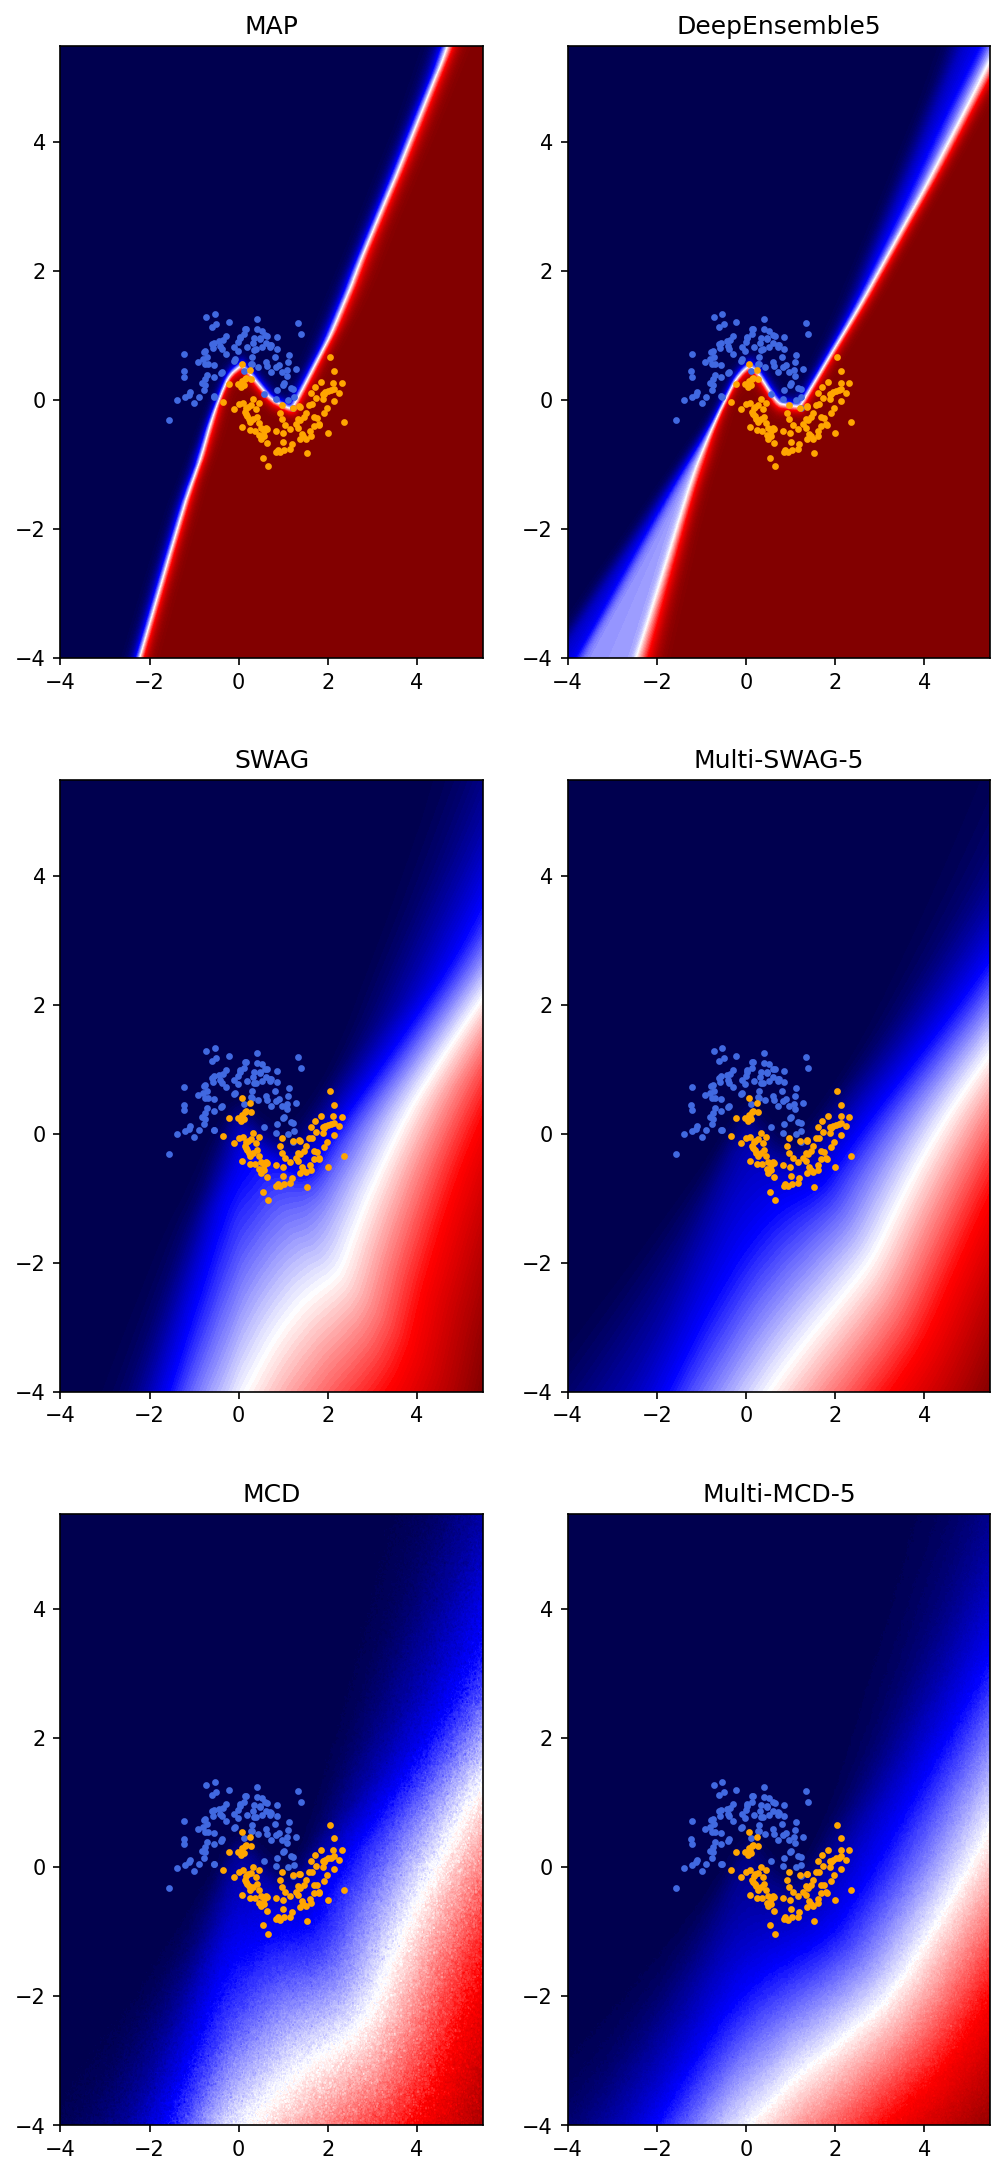

In [25]:
from util import plot_all_models, evaluate_models
model_dict = {
    "MAP": max_a_p,
    "DeepEnsemble5": deep_ensemble_5,
    "SWAG": swag,
    "Multi-SWAG-5": multi_swag_5,
    "MCD": mcd,
    "Multi-MCD-5": multi_mcd_5
}
evaluate_models(model_dict, test_data_x, test_data_y)
plot_all_models(model_dict, train_data_x, train_data_y, plot_density)

If you have done everything correctly, you should gain roughly 93% of the test accuracy for all models. We also implemented the adapted callibration error (ACE) in the util file. However, as our task is rather simple, a comparison of callibration errors is not very meaningful.

The resulting classification boundaries of all models should be very different. The MAP has a very narrow boundary while the others get more uncertainty in the area that is far from the training data.